# Explore regridding

This notebook is simply for exploring the regridding options via xESMF, to make sure results look OK and to get an understanding of how intensive the process can be, which is useful for calibrating slurm jobs. 

In [1]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

from config import (
    target_grid_fp,
    cmip6_dir,
    SCRATCH_DIR,
    model_inst_lu,
    transfers_config,
)

# ignore serializationWarnings from xarray for datasets with multiple FillValues
import warnings

warnings.filterwarnings("ignore", category=xr.SerializationWarning)

Open a dataset containing a possible target grid. One posisble grid is the NCAR CESM2 grid, which we know has "half pixels" along the 90°N and -90°N rows.

In [2]:
model = "CESM2-WACCM"
scenario = "ssp585"

inst = model_inst_lu[model]
variant = transfers_config.prod_variant_lu[model]
var_id = "tas"
table_id = "Amon"

dst_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[0]

dst_ds = xr.open_dataset(target_grid_fp)

Okay we have realized that the CESM2 grid is kinda messed up, in that the top and bottoms rows of grid points include 90°N and -90°N respectively, which is implies pixels that are half the size of all others. Take note of the sizes of the latitude bounds intervals in the *lat_bnds variable:

In [3]:
print(f"Southern 5 latitude values: {np.round(dst_ds.lat.values[:5], 4)}")
print(
    f"Corresponding cell bounds interval sizes: {[round(b2 - b1, 4) for b1, b2 in dst_ds.lat_bnds[:5].values]}\n"
)
print(f"Northern 5 latitude values: {np.round(dst_ds.lat.values[-5:], 4)}")
print(
    f"Corresponding cell bounds interval sizes: {[round(b2 - b1, 4) for b1, b2 in dst_ds.lat_bnds[-5:].values]}"
)

Southern 5 latitude values: [-90.     -89.0576 -88.1152 -87.1728 -86.2304]
Corresponding cell bounds interval sizes: [0.4712, 0.9424, 0.9424, 0.9424, 0.9424]

Northern 5 latitude values: [86.2304 87.1728 88.1152 89.0576 90.    ]
Corresponding cell bounds interval sizes: [0.9424, 0.9424, 0.9424, 0.9424, 0.4712]


Apparently this doesn't seem like an issue in the modeling community, as we know this is a popular model, and this same grid was used for other models in our ensemble (TaiESM1 and NorESM2-MM).

I suppose it doesn't violate CF Convention either, in that the `lat_bnds` variable [always contains the gridpoint](https://cfconventions.org/cf-conventions/cf-conventions.html#cell-boundaries), and the gridpoints [do not have to be pixel centers](https://cfconventions.org/cf-conventions/cf-conventions.html#coordinate-types).

We know we want our target grid to have a longitude axis of [-180°E, 180°E) instead of the [0, 360°E) axis that the CMIP6 contributions all seem to have.

Here is how we will do the shifting:

In [4]:
# put this into a function for reuse below
def shift_longitude(ds):
    # re-writing this variable in to help with exploration & re-running this cell
    lon_enc = ds["lon"].encoding
    lon_attrs = ds["lon"].attrs
    # subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
    ds.coords["lon"] = (ds.coords["lon"] + 180) % 360 - 180
    ds["lon"].encoding = lon_enc
    ds["lon"].attrs = lon_attrs
    ds["lon"].attrs["valid_min"] = -180
    ds["lon"].attrs["valid_max"] = 360
    # sort and verify
    ds = ds.sortby(ds.lon, ascending=True)
    # Set new bnds, might not be necessary, but it's a safe bet.
    # We know the pixels are exactly 1.25° long in the longitude direction
    new_lon_bnds = np.array([[x - 0.625, x + 0.625] for x in ds["lon"].values])
    ds.lon_bnds.data = new_lon_bnds

    return ds

In [5]:
# re-writing this variable in to help with exploration & re-running this cell
dst_ds = xr.open_dataset(target_grid_fp)
dst_ds = shift_longitude(dst_ds)

print(f"Western 5 longitude values: {dst_ds.lon.values[:5]}")
print(f"Corresponding cell bounds:\n {dst_ds.lon_bnds.values[:5]}\n")
print(f"Northern 5 latitude values: {dst_ds.lat.values[-5:]}")
print(f"Corresponding cell bounds:\n {dst_ds.lat_bnds.values[-5:]}")

Western 5 longitude values: [-180.   -178.75 -177.5  -176.25 -175.  ]
Corresponding cell bounds:
 [[-180.625 -179.375]
 [-179.375 -178.125]
 [-178.125 -176.875]
 [-176.875 -175.625]
 [-175.625 -174.375]]

Northern 5 latitude values: [86.23036649 87.17277487 88.11518325 89.05759162 90.        ]
Corresponding cell bounds:
 [[85.7591623  86.70157068]
 [86.70157068 87.64397906]
 [87.64397906 88.58638743]
 [88.58638743 89.52879581]
 [89.52879581 90.        ]]


Open a dataset to regrid. First, try a monthly file of the "same" grid as this target (it is just the grid that we have shifted):

In [6]:
# getting the next file available from the above globbing
src_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[1]

# just choosing a single time slice for efficiency
src_ds = xr.open_dataset(src_fp).isel(time=[0])

Now regrid:

In [7]:
%%time
regridder = xe.Regridder(src_ds, dst_ds, 'bilinear', unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

CPU times: user 2.1 s, sys: 116 ms, total: 2.21 s
Wall time: 2.27 s


View the results (original on the left):

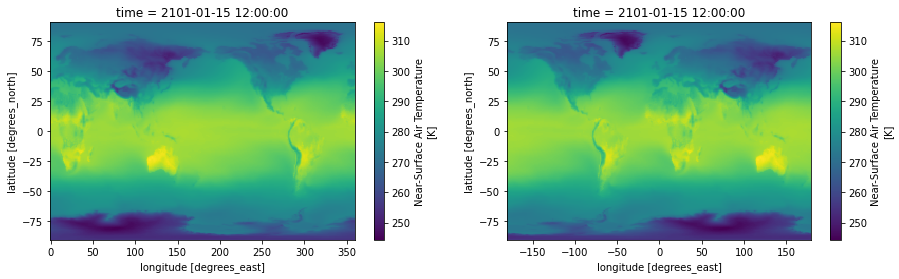

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].plot(ax=ax[0])
regrid_ds["tas"].plot(ax=ax[1])

That worked, for this dataset on the same grid. 

However, this does cause a line at the prime meridian for some datasets. For example, GFDL-ESM4:

Minimum longitude: 0.625
Maximum longitude: 359.375
Minimum latitude: -89.5
Maximum latitude: 89.5


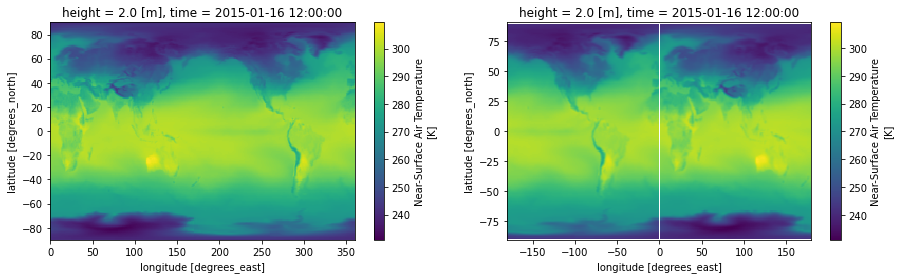

In [12]:
src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-ESM4_ssp585_r1i1p1f1_gr1_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp).isel(time=[0])
print(f"Minimum longitude: {src_ds.lon.min()}")
print(f"Maximum longitude: {src_ds.lon.max()}")
print(f"Minimum latitude: {src_ds.lat.min()}")
print(f"Maximum latitude: {src_ds.lat.max()}")

regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].plot(ax=ax[0])
regrid_ds["tas"].plot(ax=ax[1])

However, there is indeed complete coverage of the globe in this file:

In [13]:
print(f"Northern 5 latitude values: {np.round(src_ds.lat.values[-5:], 4)}")
print(
    f"Corresponding cell bounds interval sizes: {[round(b2 - b1, 4) for b1, b2 in src_ds.lat_bnds[-5:].values]}\n"
)
print(f"Western 5 longitude values: {np.round(src_ds.lon.values[:5], 4)}")
print(
    f"Corresponding cell bounds interval sizes: {[round(b2 - b1, 4) for b1, b2 in src_ds.lon_bnds[:5].values]}"
)

Northern 5 latitude values: [85.5 86.5 87.5 88.5 89.5]
Corresponding cell bounds interval sizes: [1.0, 1.0, 1.0, 1.0, 1.0]

Western 5 longitude values: [0.625 1.875 3.125 4.375 5.625]
Corresponding cell bounds interval sizes: [1.25, 1.25, 1.25, 1.25, 1.25]


So I believe the only solution we need here is to specify that the grids are periodic in longitude. [From the docs](https://xesmf.readthedocs.io/en/stable/user_api.html#xesmf.frontend.Regridder.__init__):
>Only useful for global grids with non-conservative regridding. Will be forced to False for conservative regridding.

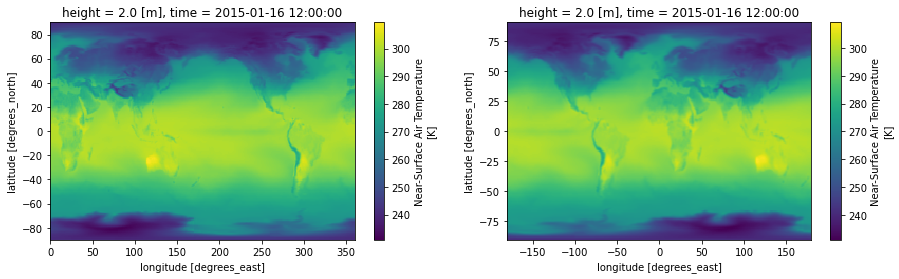

In [14]:
regridder = xe.Regridder(
    src_ds, dst_ds, "bilinear", unmapped_to_nan=True, periodic=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].plot(ax=ax[0])
regrid_ds["tas"].plot(ax=ax[1])

That appears to work well.

However, notice that the regridded dataset does not have bounds variables. They potentially get dropped since they are not consistent.
Not sure if we need them, but I kinda see it as required if we do use this CESM2 as our target grid.

In [15]:
regrid_ds

<xarray.Dataset>
Dimensions:  (time: 1, lat: 192, lon: 288, bnds: 2)
Coordinates:
  * bnds     (bnds) float64 1.0 2.0
    height   float64 ...
  * time     (time) object 2015-01-16 12:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
Data variables:
    tas      (time, lat, lon) float32 241.0 241.0 241.0 ... 241.1 241.1 241.1
Attributes: (12/47)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    ...                     ...
    tracking_id:            hdl:21.14100/b57955a9-7926-4a7e-b5cc-6c65c3c1949f
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    regrid_method:          bilinear

### More checks on CESM2 grid with xESMF utilities

Shedding some more light on the CESM2 grid - `xesmf` has some utilities for grid generation. This example is just more proof that the CESM2 grid is kinda wonky. These functions require a step size, which we cannot derive from the latitude axis of the CESM2 grid, because there are two different values. So if we use the step size used for all other pixels besides the first and last rows, 0.9424, we get a different grid:

In [24]:
xe.util.cf_grid_2d(-180, 180, 1.25, -90, 90, 0.9424)

<xarray.Dataset>
Dimensions:             (lon: 288, bound: 2, lat: 191)
Coordinates:
  * lon                 (lon) float64 -179.4 -178.1 -176.9 ... 176.9 178.1 179.4
  * lat                 (lat) float64 -89.53 -88.59 -87.64 ... 87.64 88.58 89.53
    latitude_longitude  float64 nan
Dimensions without coordinates: bound
Data variables:
    lon_bounds          (lon, bound) float64 -180.0 -178.8 ... 178.8 180.0
    lat_bounds          (lat, bound) float64 -90.0 -89.06 -89.06 ... 89.06 90.0

Although we can create a grid based on the GFDL-ESM4 grid:

In [22]:
src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-ESM4_ssp585_r1i1p1f1_gr1_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp).isel(time=[0])
new_grid = xe.util.cf_grid_2d(-180, 180, 1.25, -90, 90, np.diff(src_ds.lat.values)[0])
new_grid

<xarray.Dataset>
Dimensions:             (lon: 288, bound: 2, lat: 180)
Coordinates:
  * lon                 (lon) float64 -179.4 -178.1 -176.9 ... 176.9 178.1 179.4
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    latitude_longitude  float64 nan
Dimensions without coordinates: bound
Data variables:
    lon_bounds          (lon, bound) float64 -180.0 -178.8 ... 178.8 180.0
    lat_bounds          (lat, bound) float64 -90.0 -89.0 -89.0 ... 89.0 90.0

### How is xESMF handling nodata

It looks like the NaNs are treated as numbers in xESMF, and we will likely need to modify the datasets with masks to achieve the desired regridding.

Here is an example with a data file already on the target grid, and so we would expect values to match exactly, but they clearly don't:

In [25]:
model = "CESM2-WACCM"
scenario = "ssp585"

inst = model_inst_lu[model]
variant = transfers_config.prod_variant_lu[model]
var_id = "mrro"
table_id = "Lmon"

src_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[0]

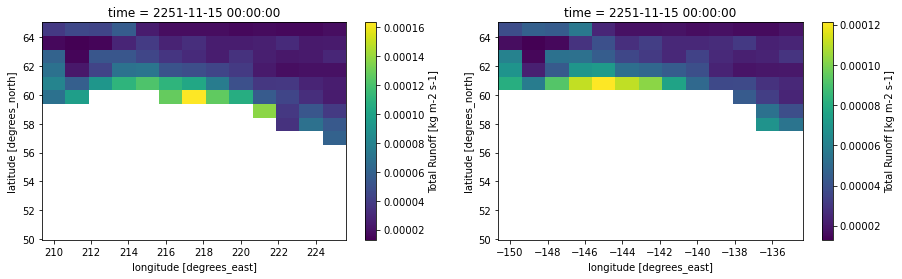

In [26]:
src_ds = xr.open_dataset(src_fp)
# lets just work on one time slice, on a bbox near the coast
src_ds = src_ds.isel(time=[10])
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

Supposedly, you only need to have one dataset with a mask variable. Let's try adding it to the source dataset:

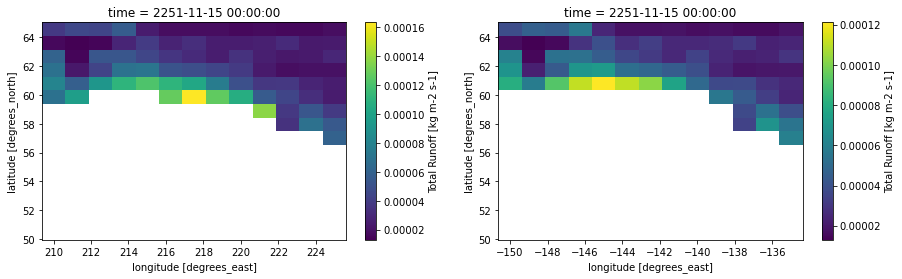

In [27]:
# add mask to the source dataset (to be regridded)
src_ds["mask"] = xr.where(~np.isnan(src_ds[var_id]), 1, 0).isel(time=0)

regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

Well that didn't seem to work. 

What if we try a different target dataset? One that has same nodata mask?

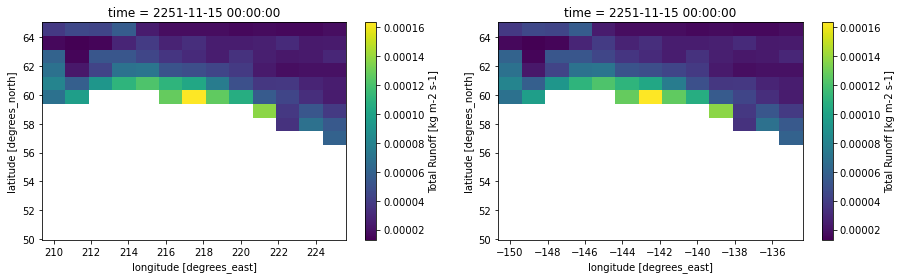

In [28]:
mrro_target_grid_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r1i1p1f1/Lmon/mrro/gn/v20190815/mrro_Lmon_CESM2-WACCM_ssp370_r1i1p1f1_gn_201501-206412.nc"
)

# define target grid
mrro_dst_ds = xr.open_dataset(mrro_target_grid_fp).isel(time=0).drop_vars("time")
# check that the nodata pixels are the same on a subsection of the arrays the does not overlap the boundaries
# src ds is on 0-360
assert np.all(np.isnan(src_ds[var_id].isel(time=0)) == np.isnan(mrro_dst_ds[var_id]))

mrro_dst_ds = shift_longitude(mrro_dst_ds)

regridder = xe.Regridder(src_ds, mrro_dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

That seems to work. Note that we ensured the nodata masks are the same prior to shifting the target dataset to [-180°E, 180°E). Double check that the values are the same:

In [29]:
assert np.array_equal(
    src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)),
    regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)),
    equal_nan=True,
)

Yep. So another check, does this work without a `mask` variable in the source dataset?

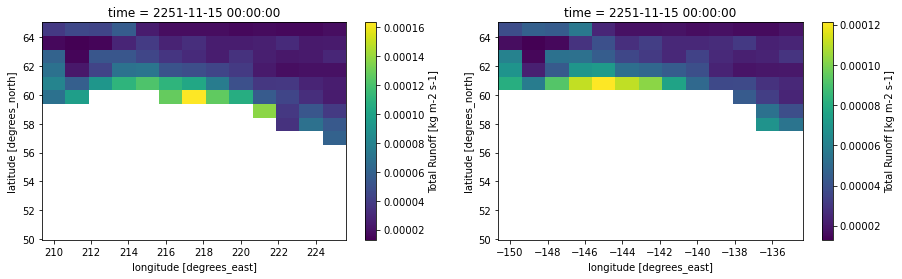

In [30]:
regridder = xe.Regridder(
    src_ds.drop_vars("mask"), dst_ds, "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

It does not. So it looks like we will need a `mask` variable in the source dataset regardless. 

What if we put a `mask` variable in the original target dataset?

Well, it turns out that is not as easy as it would seem! Notice what the mask looks like:

In [31]:
xr.where(~np.isnan(mrro_dst_ds[var_id]), 1, 0)

<xarray.DataArray 'mrro' (lat: 192, lon: 288)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8

And how it becomes something else when assigned to the original target dataset:

<xarray.DataArray 'mask' (lat: 192, lon: 288)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8


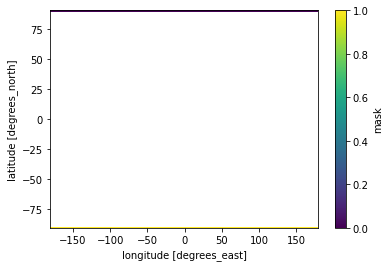

In [32]:
dst_ds["mask"] = xr.where(~np.isnan(mrro_dst_ds[var_id]), 1, 0)
print(dst_ds["mask"])
dst_ds["mask"].plot()

It looks like the latitude values are slightly different, which is causing a conflict in copying the mask data values in for all but those with -90 or 90 latitude:

In [36]:
mask = xr.where(~np.isnan(mrro_dst_ds[var_id]), 1, 0)
mask.lat.values[:5] == dst_ds.lat.values[:5]

array([ True, False, False, False, False])

In [37]:
print(mask.lat.values[:5])
print(dst_ds.lat.values[:5])

[-90.         -89.0575943  -88.11518097 -87.17277527 -86.23036957]
[-90.         -89.05759162 -88.11518325 -87.17277487 -86.23036649]


Yeah it looks like these are different in each file too, here are the first few outputs of `ncdump -v lat` on each of the target files in play here:

```
-90, -89.0575942993164, -88.1151809692383, -87.1727752685547,
-90, -89.0575916230366, -88.1151832460733, -87.1727748691099,
```

However, these are the same down to 5 decimal places, which should correspond to distances of ~1m. This looks like a floating point noise writing goof somewhere along the way. 

So since we have same values here, we can essentially just choose whatever array of latitude values we want to go with here. We will just use the latitude values from the original destination dataset:

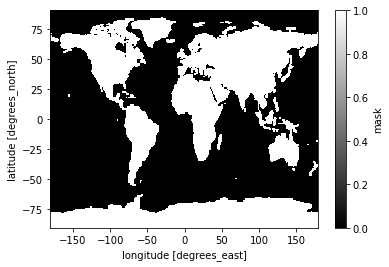

In [38]:
dst_ds["mask"] = (["lat", "lon"], mask.values)
dst_ds["mask"].plot(cmap="binary_r")

There we go. Now let's see if that works for the regridding:

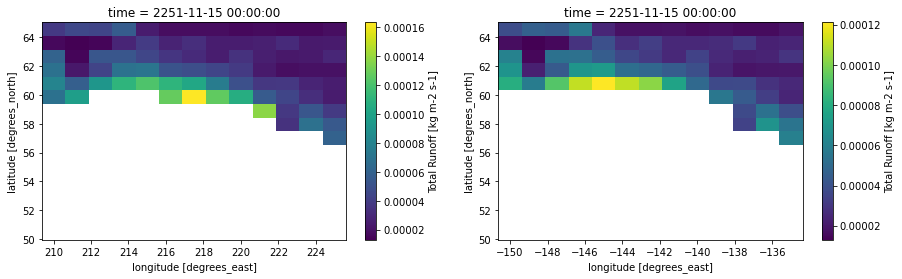

In [39]:
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

Nope. 

So it looks like we need:

1. add a `mask` variable in the source grid dataset for any that have NaN values
2. a target grid dataset with NaN values in the same places as the mask in the source dataset.


Of course, 2. is not possible for datasets not on the common grid already, so we need to figure out what will work here maybe. Maybe just matching variables is our best bet?

As far as implementing this programmatically, it might be best to first check if there are any NaNs in the dataset to be regridded, and only add the `mask` variable if we find any, and load up the desired target file that has the NaNs we need? 

Also, we see below that the `mask` variable persists in the regridded output, so we should drop that variable before writing the .nc file.

In [40]:
regrid_ds

<xarray.Dataset>
Dimensions:  (time: 1, lat: 192, lon: 288)
Coordinates:
  * time     (time) object 2251-11-15 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
Data variables:
    mrro     (time, lat, lon) float32 3.289e-18 5.006e-18 -7.432e-19 ... nan nan
    mask     (lat, lon) int64 1 1 ... -9223372036854775808 -9223372036854775808
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    branch_method:          standard
    branch_time_in_child:   766500.0
    branch_time_in_parent:  766500.0
    case_id:                1678
    cesm_casename:          b.e21.BWSSP585extcmip6.f09_g17.CMIP6-SSP5-8.5ext-...
    ...                     ...
    parent_activity_id:     CMIP
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       CESM2-WACCM
    parent_time_units:      days since 0001-01-01 00:00:00
    regrid_method:          bilinear

It is worth checking what things would look like for both options with a dataset that is not already on the target grid. 

In this case, it looks like 0 is the "mask" value, not NaN:

In [41]:
model = "GFDL-ESM4"
scenario = "ssp585"

inst = model_inst_lu[model]
variant = transfers_config.prod_variant_lu[model]
var_id = "mrro"
table_id = "Lmon"

src_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[0]

src_ds = xr.open_dataset(src_fp)
# lets just work on one time slice, on a bbox near the coast
src_ds = src_ds.isel(time=[10])

src_ds.mrro

<xarray.DataArray 'mrro' (time: 1, lat: 180, lon: 288)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-11-16 00:00:00
Attributes:
    long_name:        Total Runoff
    units:            kg m-2 s-1
    cell_methods:     area: mean where land time: mean
    ocean_fillvalue:  0.0
    cell_measures:    area: areacella
    standard_name:    runoff_flux
    interp_method:    conserve_order1
    original_name:    mrro
    comment:          land_area = areacella * sftlf * 0.01

Notice the "ocean_fillvalue": 0. Great choice!!!!!!@#\$@#$%@

So that is going to complicate things, because it looks like 0 does occur inside the land as well:

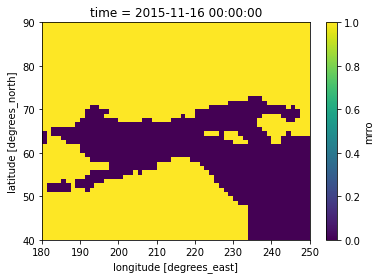

In [42]:
(src_ds.mrro == 0).sel(lat=slice(40, 90), lon=slice(180, 250)).plot()

You can see this propogated in the regridding. Make the mask:

In [43]:
src_ds["mask"] = xr.where(src_ds[var_id] != 0, 1, 0).isel(time=0)

Including `mask` variable to the source dataset only:

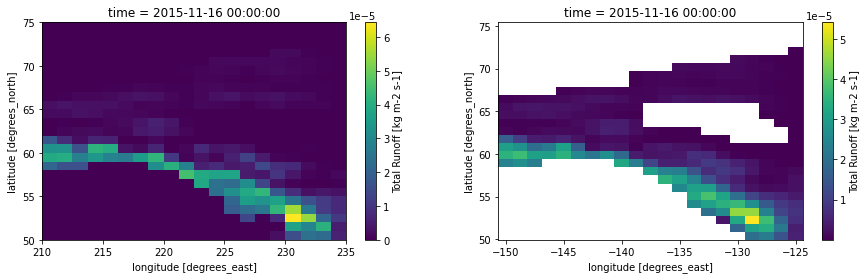

In [44]:
regridder = xe.Regridder(src_ds, mrro_dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 75), lon=slice(210, 235)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 75), lon=slice(-150, -125)).plot(ax=ax[1])

So, yeah.. more work to be done here..

### Test regridding object re-use

Now ensure that we can use the same regridding object on a file with a different number of time steps (e.g. a daily file) but with the same grid. This will help us be more efficient. According to the docs, [this should be acceptable](https://xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html).

In [15]:
daily_src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/day/tas/gr1/v20180701/tas_day_GFDL-ESM4_ssp585_r1i1p1f1_gr1_20150101-20341231.nc"
)
daily_src_ds = xr.open_dataset(daily_src_fp)

Regrid:

In [16]:
%%time
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

CPU times: user 8.6 s, sys: 2.6 s, total: 11.2 s
Wall time: 12.3 s


Plot results:

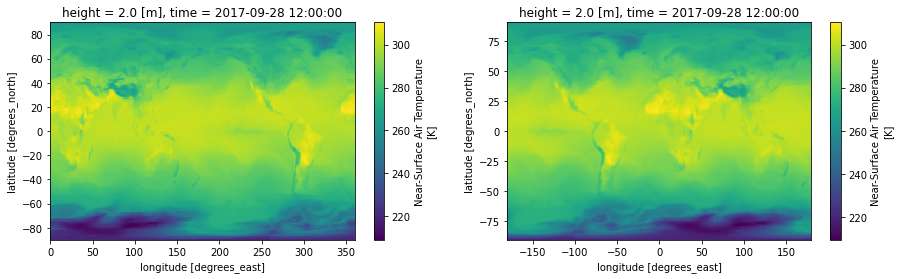

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
daily_src_ds["tas"].isel(time=1000).plot(ax=ax[0])
daily_regrid_ds["tas"].isel(time=1000).plot(ax=ax[1])

Plot the time series at a single point to make sure the broadcasting is correct (top is original):

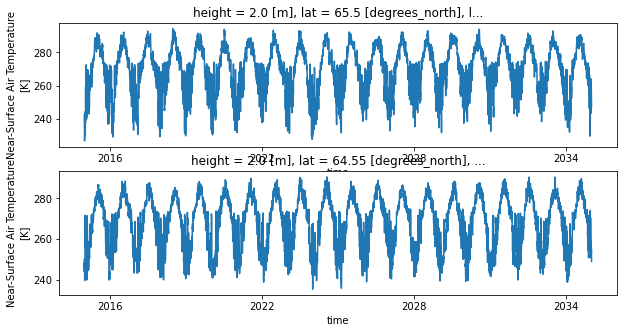

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
test_lon = 180 + (180 - 148)  # lon domain is approx (0, 360)
test_lat = 65
daily_src_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[0])
daily_regrid_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[1])

Great. So we can use an established `regridder` object with weights to regrid multiple files, provided they have the same grid. Also, note that regridding the daily file took approximately 30s.

## Optimizing for multiple files

This section will be used to determine a reasonable number of files to regrid in a single `sbatch` job. We will attempt to regrid a handful of daily files using `dask.delayed`, and compare.

In [11]:
import dask

Choose some daily temperature files to regrid. There should be 20 in this glob:

In [20]:
src_fps = list(
    cmip6_dir.glob(
        "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/*/r1i1p1f1/day/tas/gr1/v20180701/*.nc"
    )
)
len(src_fps)

20

Define a function to regrid and write a file:

In [26]:
@dask.delayed
def regrid_file(fp, regridder, out_fp):
    src_ds = xr.open_dataset(fp)
    regrid_ds = regridder(src_ds)
    regrid_ds.to_netcdf(out_fp)

    return out_fp

Make and output dir:

In [27]:
out_dir = SCRATCH_DIR.joinpath("regrid_testing")
out_dir.mkdir(exist_ok=True)

Create the regridder object:

In [ ]:
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

Run the regridding:

In [30]:
results = []
for fp in src_fps:
    out_fp = out_dir.joinpath(fp.name.replace(".nc", "_regrid.nc"))
    results.append(regrid_file(fp, regridder, out_fp))

In [31]:
%%time
dask.compute(results)

CPU times: user 6min 37s, sys: 5min 27s, total: 12min 5s
Wall time: 6min 34s


([PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20550101-20741231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20950101-21001231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20150101-20341231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredil

Okay this seems like an efficient and simple way to move forward. If we can process 20 daily files in under 6 minutes, we should be safe with only trying to process ~200 files in under the two hours. This should inform our generation of batch files, with each batch file containing at most 200 hundred files. 